In [1]:
import sys
sys.path.insert(1, '/Users/Andrew/Documents/PhD/Scripts/Python/pygplates_rev12')
import pygplates
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm

8137


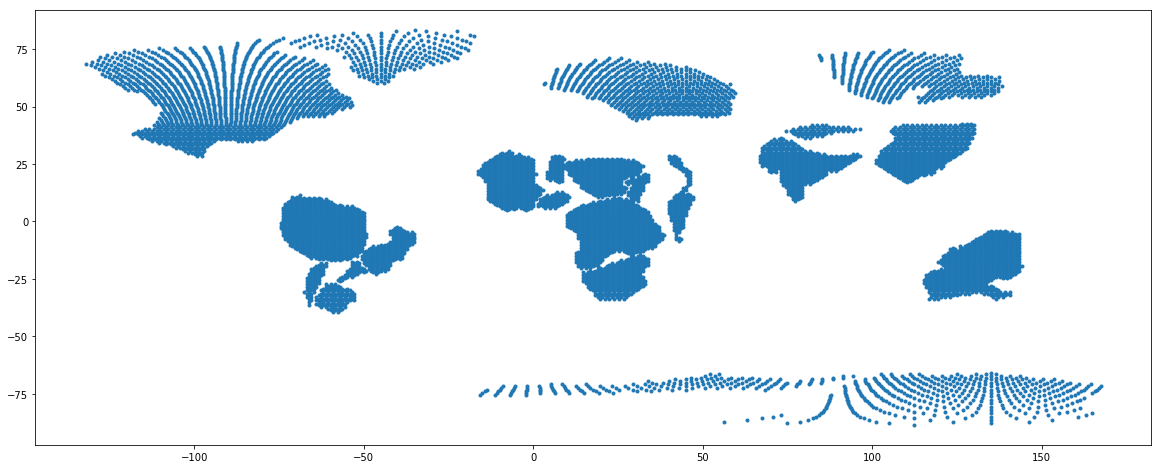

In [2]:
plate_id_for_RMS = [1001,
                    1002,
                    2201,
                    2202,
                    2203,
                    2204,
                    2205,
                    2206,
                    3001,
                    4001,
                    5501,
                    5503,
                    5504,
                    6001,
                    6601,
                    6603,
                    6604,
                    7701,
                    7702,
                    7703,
                    7704,
                    7705,
                    7706,
                    7709,
                    8001,
                    8004,
                    8802,
                    8803,
                    8804]

#plate_id_for_RMS = 8004

# specify the file containing the global coastline geometries
input_feature_filename = "/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Rod-Gondw_intraplate_20161207.gpml"

# load the features into an object called 'features'
features = pygplates.FeatureCollection(input_feature_filename)

# make an empty object in which to store the selected features
selected_features = []

# iterate over every feature in the coastline file, and append the features that match our criteria
for feature in features:
    if feature.get_reconstruction_plate_id() in plate_id_for_RMS:
        selected_features.append(feature)
        
# The partition_into_plates function requires a rotation model, since sometimes this would be
# necessary even at present day (for example to resolve topological polygons)
rotation_model=pygplates.RotationModel('/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Rod-Gondw_Palaeozoic_20161212.rot')


velocity_domain_features = pygplates.FeatureCollection('/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/healpix_mesh_64.gpmlz')

# partition features
partitioned_points = pygplates.partition_into_plates(selected_features,
                                                       rotation_model,
                                                       velocity_domain_features)

# Get only the multipoint features that fall within the selected polygon(s)
features_within_selected_plate = []
for feature in partitioned_points:
    if feature.get_reconstruction_plate_id() in plate_id_for_RMS:
        features_within_selected_plate.append(feature)

lon = []
lat = []

for feature in features_within_selected_plate:
    for geometry in feature.get_geometries():
        lat.append(geometry.to_lat_lon_array()[:,0])
        lon.append(geometry.to_lat_lon_array()[:,1])
    
lon = np.concatenate(lon)
lat = np.concatenate(lat)

import matplotlib.pyplot as plt
%matplotlib inline

print len(lon)

fig = plt.figure(figsize=(20,8),facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)#, axisbg='#b6b6b0')
ax.plot(lon[:],lat[:],'.')
plt.show()


In [3]:
max_time = 1000.
delta_time = 1.
plate_id = plate_id_for_RMS

RMS_list = []

for feature, plate in zip(features_within_selected_plate,plate_id):
    #print feature
    tmp1 = []
    for time in np.arange(520,max_time+1.,delta_time): 
        #print time
        velocity_magnitude=[]
        # Reconstruct the point features.
        reconstructed_feature_geometries = []
        pygplates.reconstruct(feature, rotation_model, reconstructed_feature_geometries, time)
        #print reconstructed_feature_geometries
    # Get the rotation from 'time+delta' to 'time', and the feature's reconstruction plate ID.
        equivalent_stage_rotation = rotation_model.get_rotation(
            time, 
            plate, 
            time+delta_time)

        for reconstructed_feature_geometry in reconstructed_feature_geometries:      
            # Calculate a velocity for each reconstructed point over the delta time interval.
            #print reconstructed_feature_geometry
            velocity_vector = pygplates.calculate_velocities(
                reconstructed_feature_geometry.get_reconstructed_geometry(),
                equivalent_stage_rotation,
                delta_time,
                pygplates.VelocityUnits.cms_per_yr)

            velocity_magnitude_azimuth = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                                    reconstructed_feature_geometry.get_reconstructed_geometry(),
                                    velocity_vector)

            velocity_magnitude.append(velocity_magnitude_azimuth[0])

        RMS_velocity_for_stage = np.sqrt(np.mean(np.square(np.asarray(velocity_magnitude))))
    #print RMS_velocity_for_stage
        tmp1.append(RMS_velocity_for_stage)

    RMS_list.append(tmp1)
#plt.plot(np.arange(520,max_time+1.,delta_time),RMS_list)
#plt.ylim((0,10))
#plt.show()


In [4]:
RMS_list[13][180]

4.1825540035798134

In [5]:
times = np.arange(520,max_time+1.,delta_time)

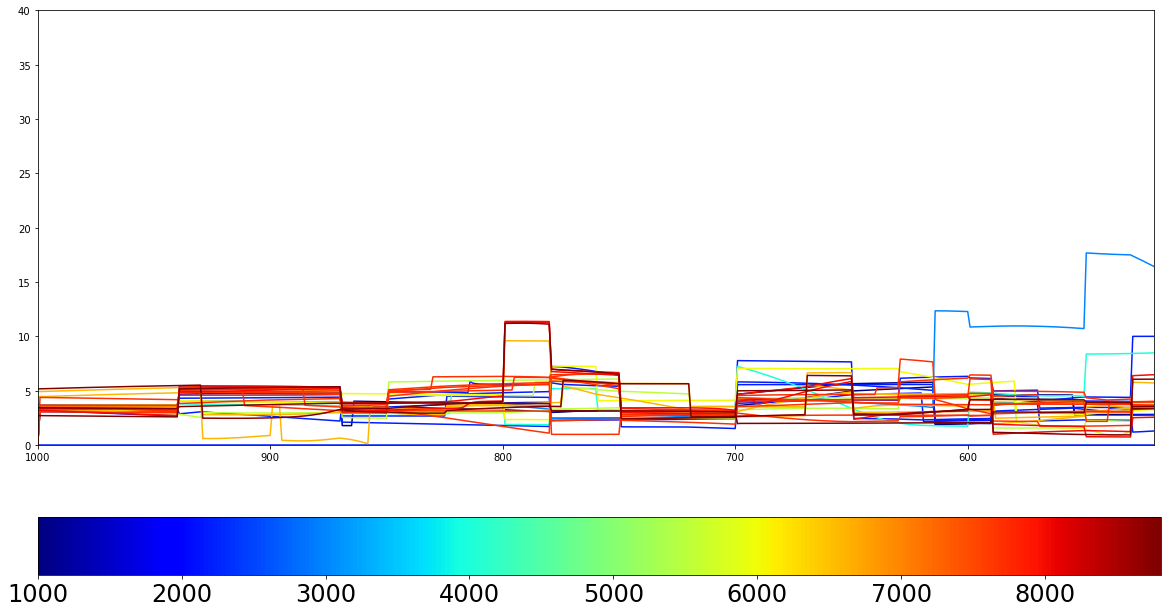

In [6]:
fig = plt.figure(figsize=(20,8),facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set(xlim=[1000,520], ylim=[0,40])
norm=mpl.colors.Normalize(vmin=1000, vmax=8804)
my_cmap = cm.jet
for x,y in zip(RMS_list,plate_id_for_RMS):
    m = cm.ScalarMappable(norm=norm, cmap=my_cmap)
    color1 = m.to_rgba(y)
    plt.plot(times,x,c=color1)
ax2 = fig.add_axes([0.125, -0.10, .78, 0.1])
ax2.tick_params(labelsize=24)#('Time (Ma)')
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=my_cmap,
                                   norm=norm,
                                   orientation='horizontal')
    
plt.show()


In [7]:
RMS_np = np.asarray(RMS_list)

In [8]:
RMS_np_ave = np.average(RMS_np, axis=0) #compute average at each time slice
RMS_ave_overall_plot = np.zeros(np.shape(RMS_np_ave)) #create dummy array of same size to plot overall average
RMS_ave_overall = np.average(RMS_np_ave) #extract average value over all time slices
RMS_ave_overall_plot.fill(RMS_ave_overall)  #fill dummy array with overall average

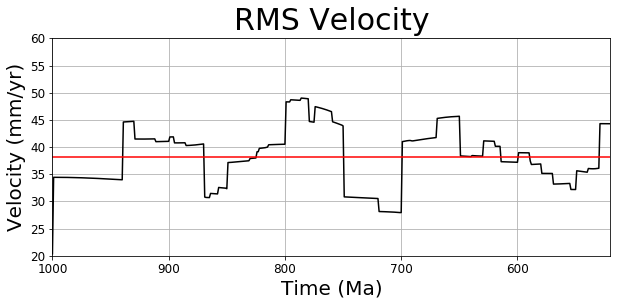

In [13]:
fig = plt.figure(figsize=(10,4),facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set(xlim=[1000,520], ylim=[20,60])
ax.plot(times,RMS_np_ave*10, 'k')
ax.plot(times,RMS_ave_overall_plot*10, 'r')
ax.set_xlabel('Time (Ma)', fontsize=20)
ax.set_ylabel('Velocity (mm/yr)', fontsize=20)
ax.set_title('RMS Velocity', fontsize=30, y=1.01)
ax.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('RMS_velocity.svg', bbox_inches='tight')